# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2025-09-17 12:33:37.587901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [4]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [5]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {2: 1000, 0: 1000, 4: 1000, 5: 1000, 1: 1000, 3: 1000, 6: 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={2: 600, 1: 600, 0: 600, 3: 600, 5: 600, 4: 600, 6: 600}
val  : total=1400, per-class={1: 200, 6: 200, 5: 200, 4: 200, 3: 200, 2: 200, 0: 200}
test : total=1400, per-class={0: 200, 6: 200, 2: 200, 3: 200, 4: 200, 5: 200, 1: 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [6]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [7]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3520      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 5831 (22.78 KB)
Trainable params: 5831 (22.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**We call `build_model` as shown here:**

In [8]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                3520      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 5831 (22.78 KB)
Trainable params: 5831 (22.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Activation Function: relu

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 1.5429 - accuracy: 0.4545 - val_loss: 1.1875 - val_accuracy: 0.5614
Epoch 2/500
66/66 [==============================] - 0s 2ms/step - loss: 1.0228 - accuracy: 0.5917 - val_loss: 0.9336 - val_accuracy: 0.6129
Epoch 3/500
66/66 [==============================] - 0s 2ms/step - loss: 0.8788 - accuracy: 0.6383 - val_loss: 0.8615 - val_accuracy: 0.6293
Epoch 4/500
66/66 [==============================] - 0s 2ms/step - loss: 0.8192 - accuracy: 0.6614 - val_loss: 0.8164 - val_accuracy: 0.6479
Epoch 5/500
66/66 [==============================] - 0s 2ms/step - loss: 0.7806 - accuracy: 0.6755 - val_loss: 0.7890 - val_accuracy: 0.6657
Epoch 6/500
66/66 [==============================] - 0s 2ms/step - loss: 0.7550 - accuracy: 0.6886 - val_loss: 0.7703 - val_accuracy: 0.6721
Epoch 7/500
66/66 [==============================] - 0s 2ms/step - loss: 0.7321 - accuracy: 0.6983 - val_loss: 0.7520 - val_ac

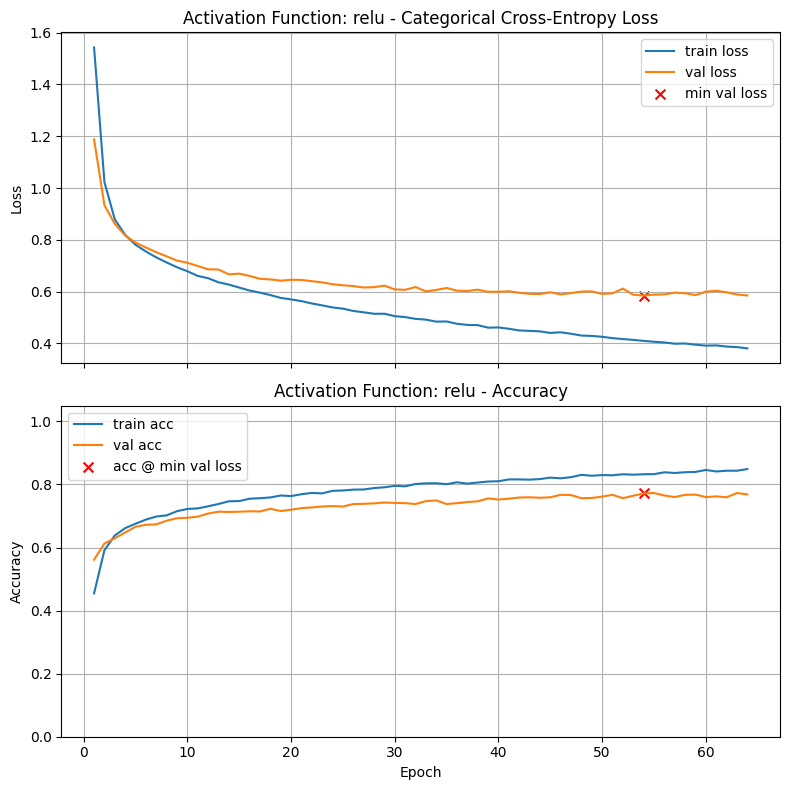

Final Training Loss:            0.3809
Final Training Accuracy:        0.8488
Final Validation Loss:          0.5852
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5849 (Epoch 54)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.6302
Test Accuracy: 0.7493

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:13

Activation Function: tanh

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 1.4785 - accuracy: 0.4552 - val_loss: 1.0789 - val_accuracy: 0.5814
Epoch 2/500
66/66 [==============================] - 0s 3ms/step - loss: 0.9947 - accuracy: 0.6026 - val_loss: 0.9213 - val_accuracy: 0.6186
Epoch 3/500
66/66 [==============================] - 0s 2ms/step - loss: 0.8934 - accuracy: 0.6340 - val_loss: 0.8591 - val_accuracy: 0.6557
Epoch 4/500
66/66 [==============================] - 0s 2ms/step - loss: 0.8426 - accuracy: 0.6579 - val_loss: 0.8223 - val_accuracy: 0.6643
Epoch 5/500
66/66 [==============================] - 0

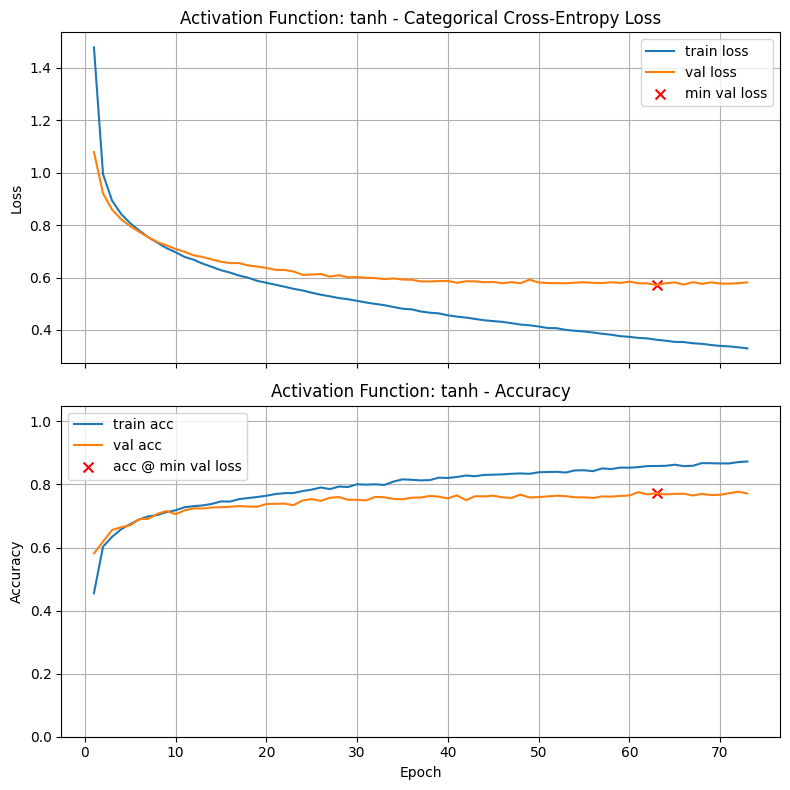

Final Training Loss:            0.3297
Final Training Accuracy:        0.8729
Final Validation Loss:          0.5814
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5711 (Epoch 63)
Validation Accuracy @ Min Loss: 0.7721

Test Loss: 0.5819
Test Accuracy: 0.7714

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:13

Activation Function: sigmoid

Epoch 1/500
66/66 [==============================] - 2s 5ms/step - loss: 1.9110 - accuracy: 0.2879 - val_loss: 1.7835 - val_accuracy: 0.4500
Epoch 2/500
66/66 [==============================] - 0s 7ms/step - loss: 1.6500 - accuracy: 0.5207 - val_loss: 1.5085 - val_accuracy: 0.5486
Epoch 3/500
66/66 [==============================] - 0s 3ms/step - loss: 1.3916 - accuracy: 0.5714 - val_loss: 1.2948 - val_accuracy: 0.5943
Epoch 4/500
66/66 [==============================] - 0s 2ms/step - loss: 1.2239 - accuracy: 0.5902 - val_loss: 1.1613 - val_accuracy: 0.6114
Epoch 5/500
66/66 [==============================] 

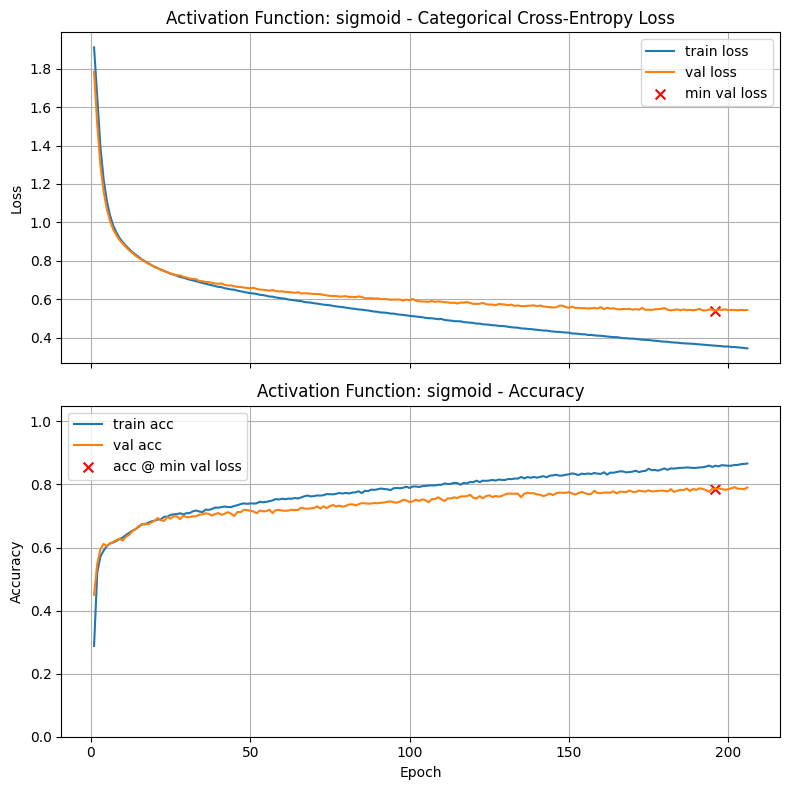

Final Training Loss:            0.3444
Final Training Accuracy:        0.8664
Final Validation Loss:          0.5440
Final Validation Accuracy:      0.7907
Minimum Validation Loss:        0.5406 (Epoch 196)
Validation Accuracy @ Min Loss: 0.7857

Test Loss: 0.5518
Test Accuracy: 0.7750

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:44


In [9]:
# Your code here. Add as many cells as you need.
activation = ['relu', 'tanh', 'sigmoid']

for func in activation:
    model = build_model(X_train.shape[1], [ (64, func, 0.0, 0.0), (32, func, 0.0, 0.0)], n_classes)
    train_and_test(model, title=f"Activation Function: {func}", verbose=1, return_history = True)

### Graded Questions

In [11]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 1            # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 1


In [13]:
# Set a1b to the validation accuracy found by this best activation function

a1b = .7857            # Replace 0.0 with your answer

In [14]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7857


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Learning Rate: 0.001

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 1.9246 - accuracy: 0.3069 - val_loss: 1.8360 - val_accuracy: 0.5214
Epoch 2/500
66/66 [==============================] - 0s 3ms/step - loss: 1.7351 - accuracy: 0.5060 - val_loss: 1.6089 - val_accuracy: 0.5514
Epoch 3/500
66/66 [==============================] - 0s 3ms/step - loss: 1.4784 - accuracy: 0.5357 - val_loss: 1.3551 - val_accuracy: 0.5793
Epoch 4/500
66/66 [==============================] - 0s 3ms/step - loss: 1.2625 - accuracy: 0.5786 - val_loss: 1.1851 - val_accuracy: 0.5929
Epoch 5/500
66/66 [==============================] - 0s 3ms/step - loss: 1.1285 - accuracy: 0.5924 - val_loss: 1.0842 - val_accuracy: 0.6043
Epoch 6/500
66/66 [==============================] - 0s 3ms/step - loss: 1.0473 - accuracy: 0.6100 - val_loss: 1.0187 - val_accuracy: 0.6086
Epoch 7/500
66/66 [==============================] - 0s 3ms/step - loss: 0.9942 - accuracy: 0.6136 - val_loss: 0.9758 - val_accurac

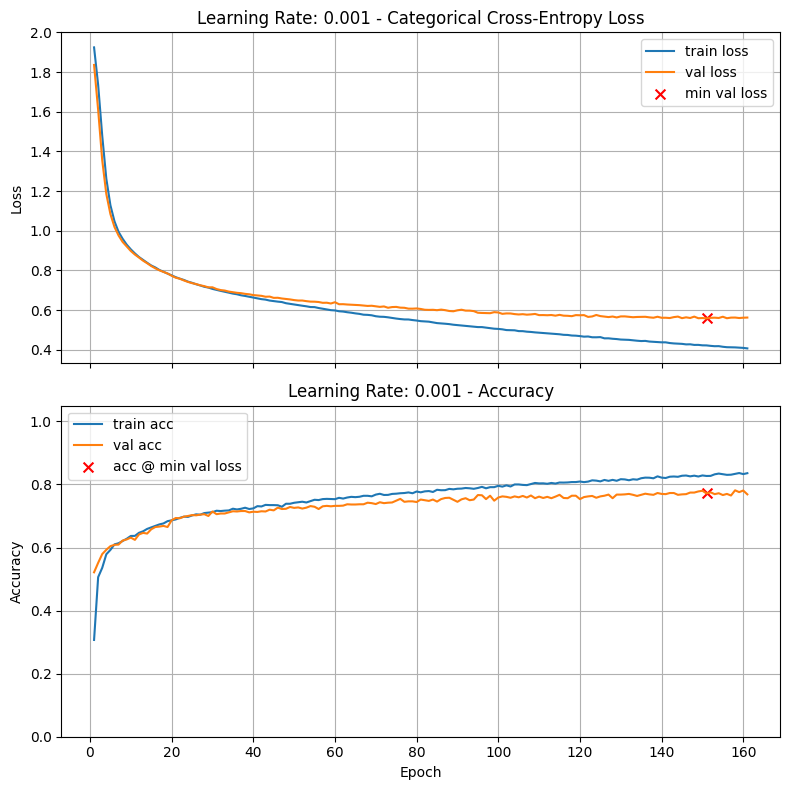

Final Training Loss:            0.4065
Final Training Accuracy:        0.8357
Final Validation Loss:          0.5619
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.5577 (Epoch 151)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5689
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:33

Learning Rate: 0.0005

Epoch 1/500
66/66 [==============================] - 1s 7ms/step - loss: 1.9273 - accuracy: 0.2286 - val_loss: 1.8756 - val_accuracy: 0.3793
Epoch 2/500
66/66 [==============================] - 0s 4ms/step - loss: 1.8243 - accuracy: 0.4386 - val_loss: 1.7617 - val_accuracy: 0.5021
Epoch 3/500
66/66 [==============================] - 0s 4ms/step - loss: 1.6874 - accuracy: 0.5038 - val_loss: 1.6053 - val_accuracy: 0.4964
Epoch 4/500
66/66 [==============================] - 0s 3ms/step - loss: 1.5265 - accuracy: 0.5238 - val_loss: 1.4489 - val_accuracy: 0.5250
Epoch 5/500
66/66 [==============================] - 0s 4

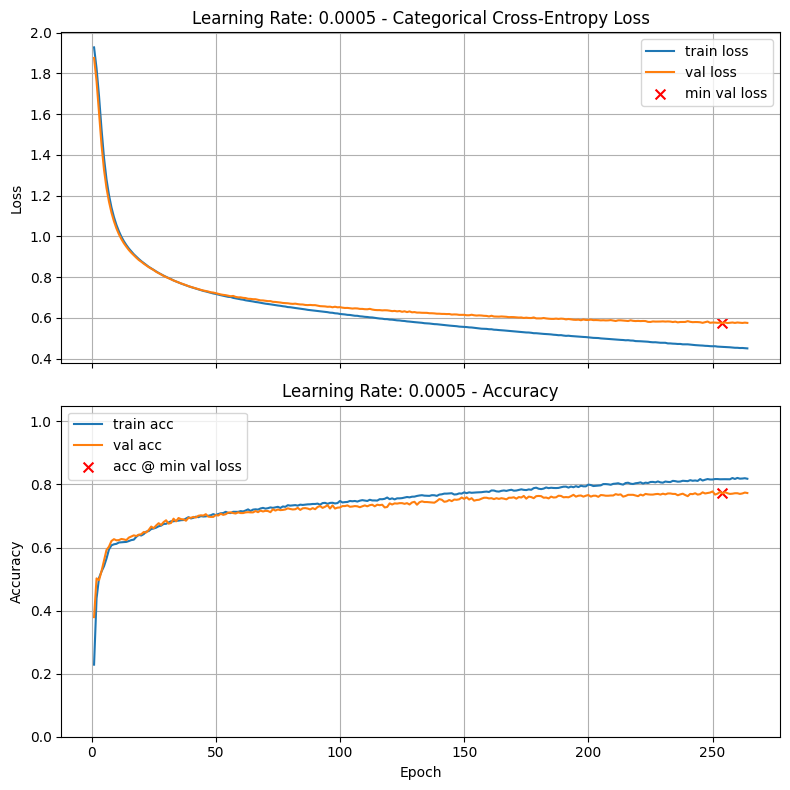

Final Training Loss:            0.4500
Final Training Accuracy:        0.8181
Final Validation Loss:          0.5751
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5741 (Epoch 254)
Validation Accuracy @ Min Loss: 0.7714

Test Loss: 0.5751
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:48

Learning Rate: 0.0001

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 2.1942 - accuracy: 0.1419 - val_loss: 2.1200 - val_accuracy: 0.1421
Epoch 2/500
66/66 [==============================] - 0s 2ms/step - loss: 2.0706 - accuracy: 0.1512 - val_loss: 2.0246 - val_accuracy: 0.1564
Epoch 3/500
66/66 [==============================] - 0s 2ms/step - loss: 1.9937 - accuracy: 0.1707 - val_loss: 1.9637 - val_accuracy: 0.1993
Epoch 4/500
66/66 [==============================] - 0s 2ms/step - loss: 1.9436 - accuracy: 0.2083 - val_loss: 1.9234 - val_accuracy: 0.2264
Epoch 5/500
66/66 [==============================] - 0s 2

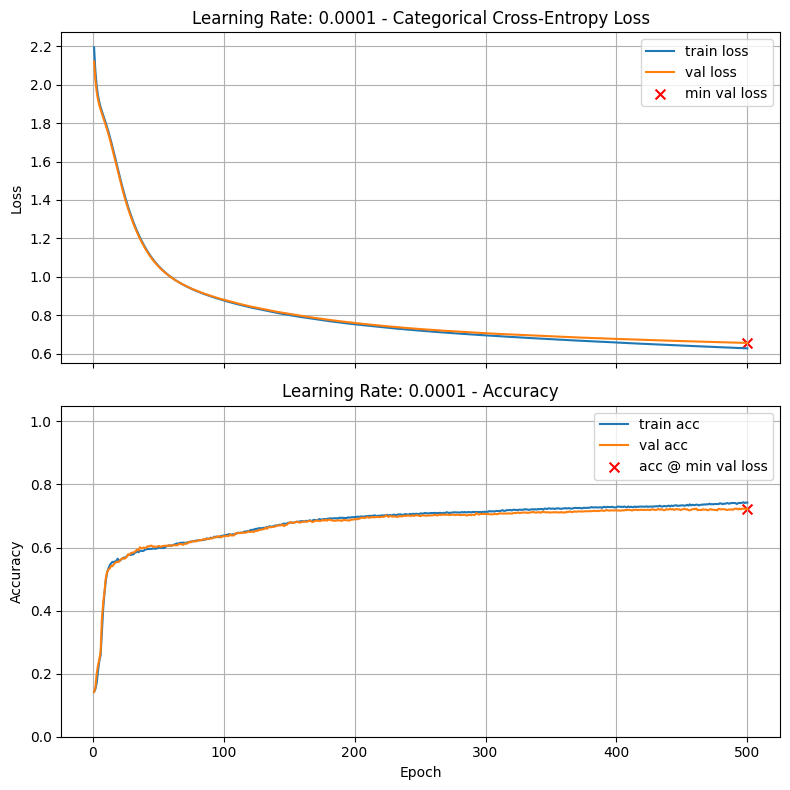

Final Training Loss:            0.6278
Final Training Accuracy:        0.7424
Final Validation Loss:          0.6559
Final Validation Accuracy:      0.7221
Minimum Validation Loss:        0.6559 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7221

Test Loss: 0.6785
Test Accuracy: 0.7179

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:01:24

Learning Rate: 5e-05

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 2.0960 - accuracy: 0.1429 - val_loss: 2.0730 - val_accuracy: 0.1429
Epoch 2/500
66/66 [==============================] - 0s 2ms/step - loss: 2.0559 - accuracy: 0.1429 - val_loss: 2.0374 - val_accuracy: 0.1429
Epoch 3/500
66/66 [==============================] - 0s 2ms/step - loss: 2.0238 - accuracy: 0.1429 - val_loss: 2.0086 - val_accuracy: 0.1429
Epoch 4/500
66/66 [==============================] - 0s 2ms/step - loss: 1.9975 - accuracy: 0.1429 - val_loss: 1.9848 - val_accuracy: 0.1429
Epoch 5/500
66/66 [==============================] - 0s 2m

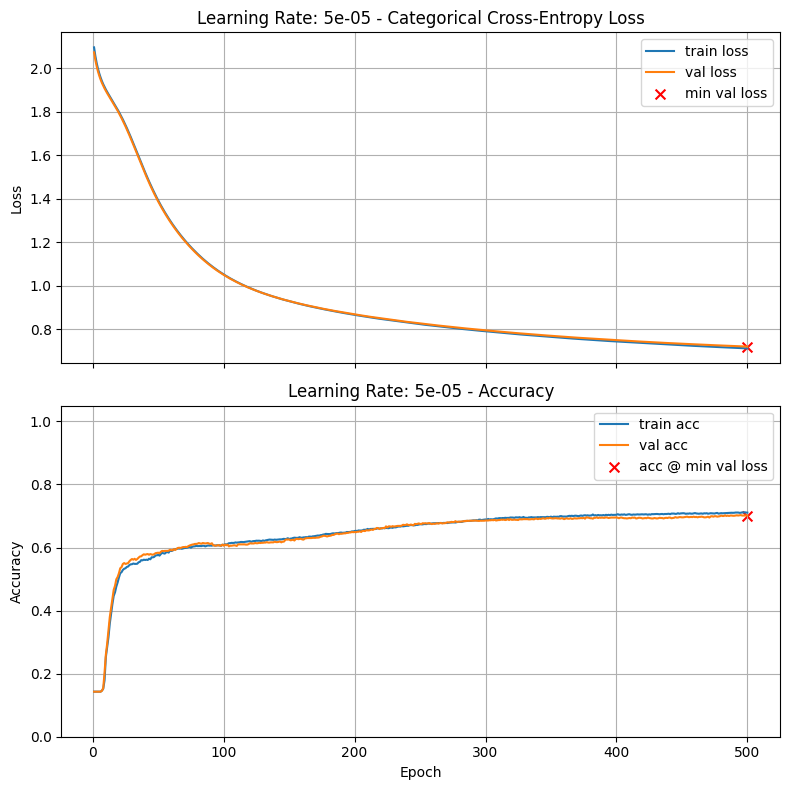

Final Training Loss:            0.7110
Final Training Accuracy:        0.7107
Final Validation Loss:          0.7191
Final Validation Accuracy:      0.7014
Minimum Validation Loss:        0.7191 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7014

Test Loss: 0.7417
Test Accuracy: 0.6929

Validation-Test Gap (accuracy): 0.008571

Execution Time: 00:01:20

Learning Rate: 1e-05

Epoch 1/500
66/66 [==============================] - 1s 5ms/step - loss: 2.0812 - accuracy: 0.1429 - val_loss: 2.0767 - val_accuracy: 0.1421
Epoch 2/500
66/66 [==============================] - 0s 2ms/step - loss: 2.0720 - accuracy: 0.1429 - val_loss: 2.0676 - val_accuracy: 0.1421
Epoch 3/500
66/66 [==============================] - 0s 2ms/step - loss: 2.0632 - accuracy: 0.1429 - val_loss: 2.0591 - val_accuracy: 0.1421
Epoch 4/500
66/66 [==============================] - 0s 3ms/step - loss: 2.0548 - accuracy: 0.1429 - val_loss: 2.0508 - val_accuracy: 0.1414
Epoch 5/500
66/66 [==============================] - 0s 3m

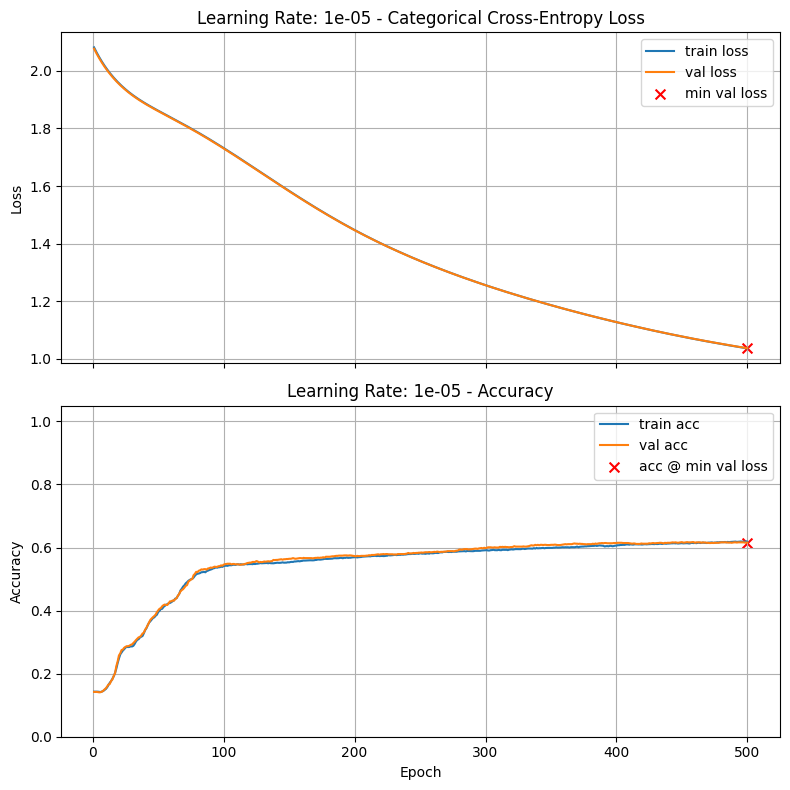

Final Training Loss:            1.0366
Final Training Accuracy:        0.6186
Final Validation Loss:          1.0371
Final Validation Accuracy:      0.6157
Minimum Validation Loss:        1.0371 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6157

Test Loss: 1.0346
Test Accuracy: 0.6286

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:01:19


In [15]:
# Your code here. Add as many cells as you need.
learning_rate = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rate:
    model = build_model(X_train.shape[1], [ (64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.0)], n_classes)
    train_and_test(model, lr_schedule=lr, title=f"Learning Rate: {lr}", verbose=1, return_history = True)

#### Graded Questions

In [16]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0.0005           # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000500


In [18]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7714            # Replace 0.0 with your answer

In [19]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7714


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3



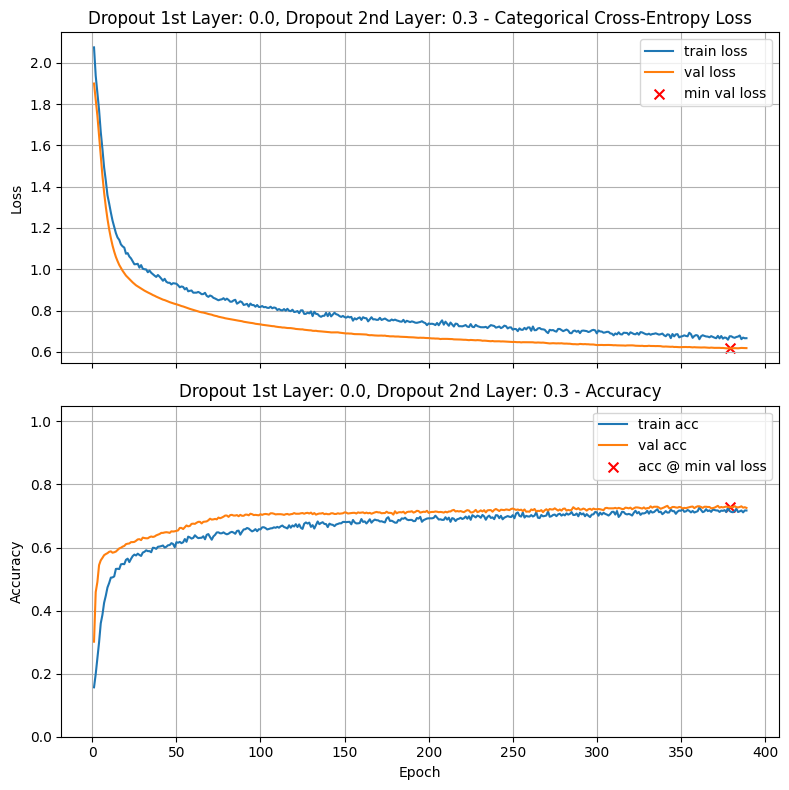

Final Training Loss:            0.6659
Final Training Accuracy:        0.7174
Final Validation Loss:          0.6178
Final Validation Accuracy:      0.7257
Minimum Validation Loss:        0.6165 (Epoch 379)
Validation Accuracy @ Min Loss: 0.7279

Test Loss: 0.6408
Test Accuracy: 0.7300

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:58

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4



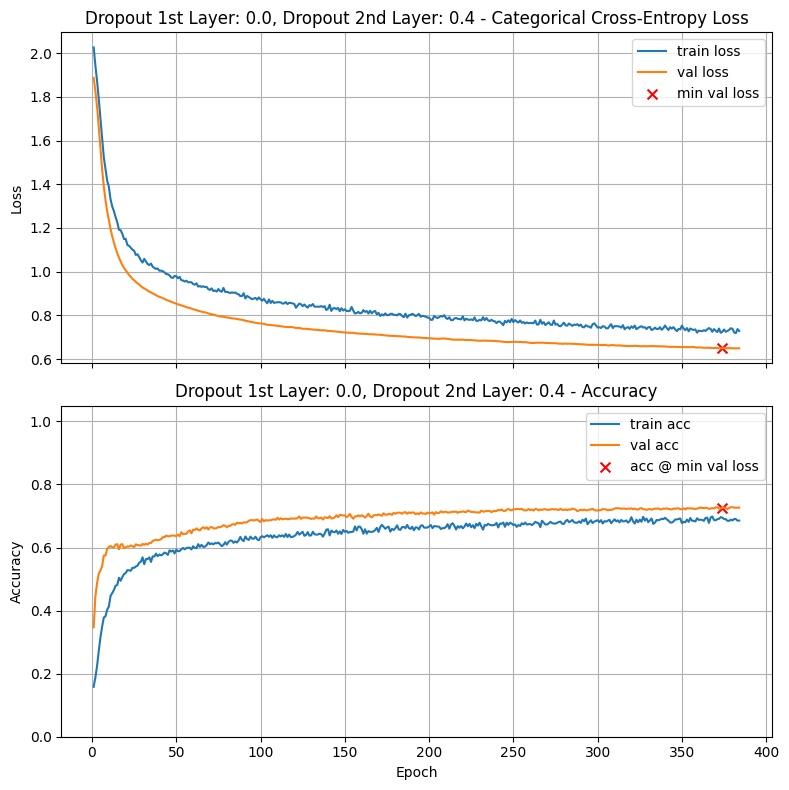

Final Training Loss:            0.7283
Final Training Accuracy:        0.6855
Final Validation Loss:          0.6491
Final Validation Accuracy:      0.7264
Minimum Validation Loss:        0.6488 (Epoch 374)
Validation Accuracy @ Min Loss: 0.7264

Test Loss: 0.6660
Test Accuracy: 0.7164

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:55

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5



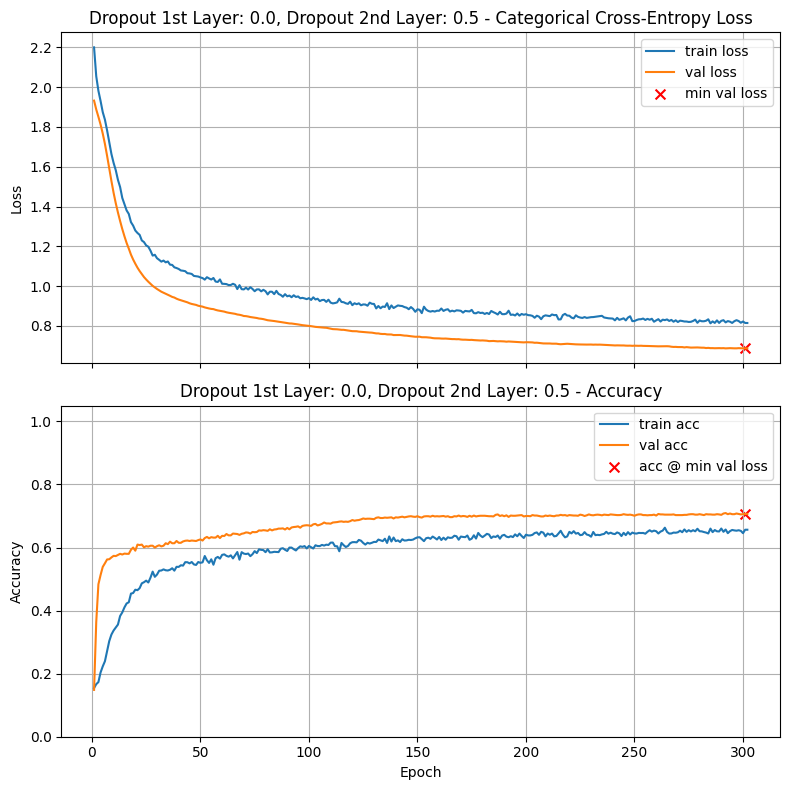

Final Training Loss:            0.8146
Final Training Accuracy:        0.6564
Final Validation Loss:          0.6871
Final Validation Accuracy:      0.7064
Minimum Validation Loss:        0.6870 (Epoch 301)
Validation Accuracy @ Min Loss: 0.7064

Test Loss: 0.7050
Test Accuracy: 0.6914

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:44

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3



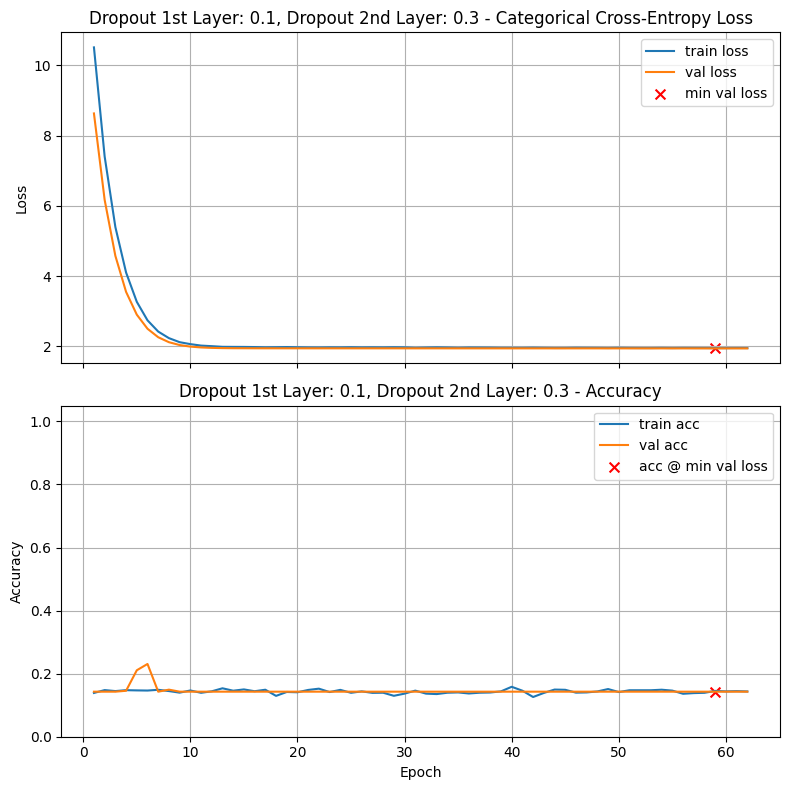

Final Training Loss:            1.9545
Final Training Accuracy:        0.1436
Final Validation Loss:          1.9463
Final Validation Accuracy:      0.1429
Minimum Validation Loss:        1.9462 (Epoch 59)
Validation Accuracy @ Min Loss: 0.1429

Test Loss: 1.9463
Test Accuracy: 0.1429

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:10

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4



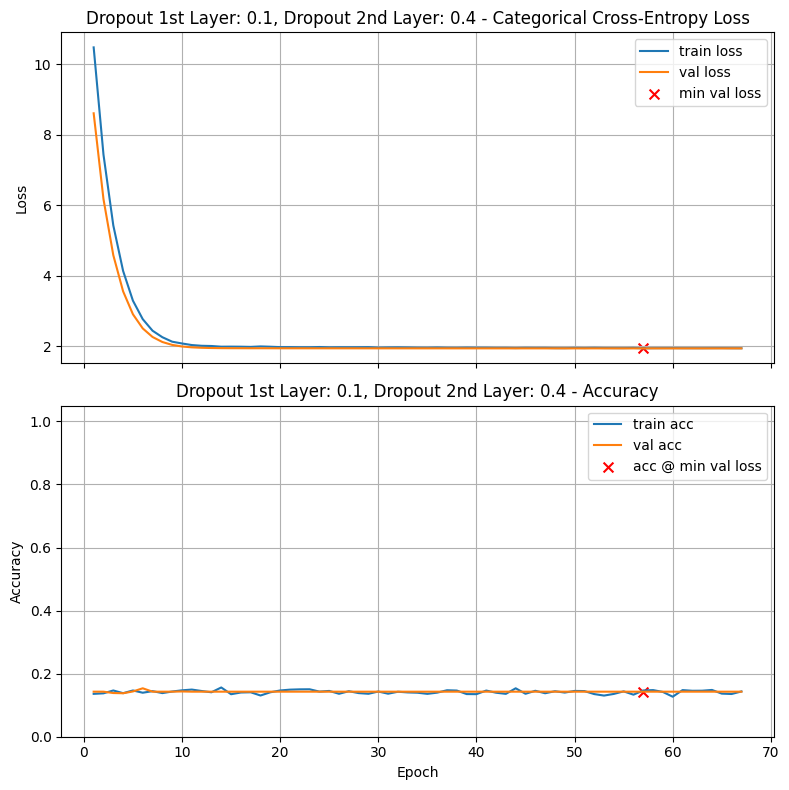

Final Training Loss:            1.9499
Final Training Accuracy:        0.1436
Final Validation Loss:          1.9462
Final Validation Accuracy:      0.1429
Minimum Validation Loss:        1.9462 (Epoch 57)
Validation Accuracy @ Min Loss: 0.1429

Test Loss: 1.9462
Test Accuracy: 0.1429

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:11

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5



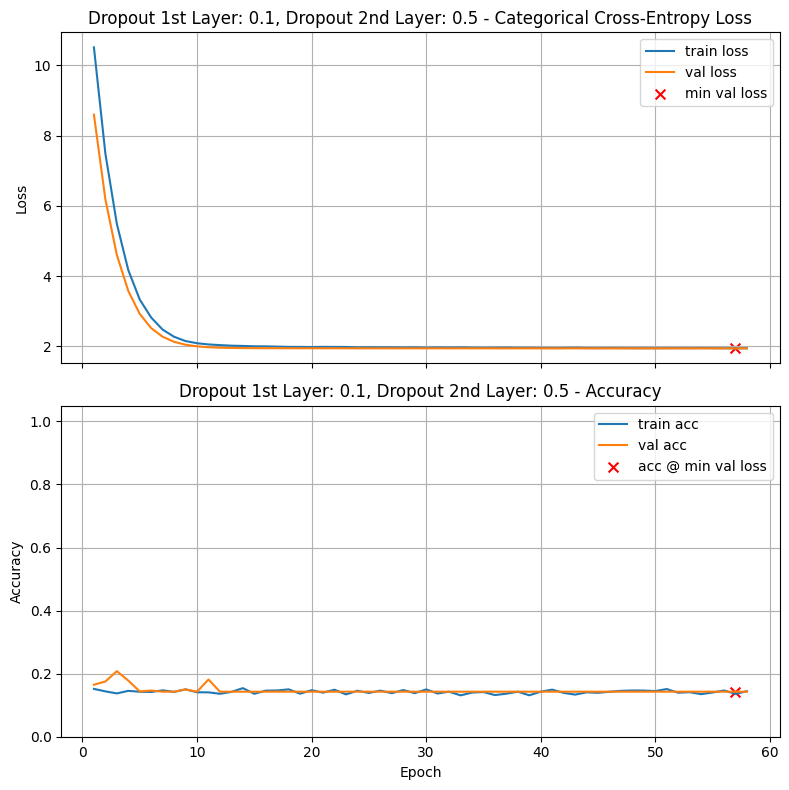

Final Training Loss:            1.9487
Final Training Accuracy:        0.1443
Final Validation Loss:          1.9461
Final Validation Accuracy:      0.1429
Minimum Validation Loss:        1.9461 (Epoch 57)
Validation Accuracy @ Min Loss: 0.1429

Test Loss: 1.9462
Test Accuracy: 0.1429

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:13

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3



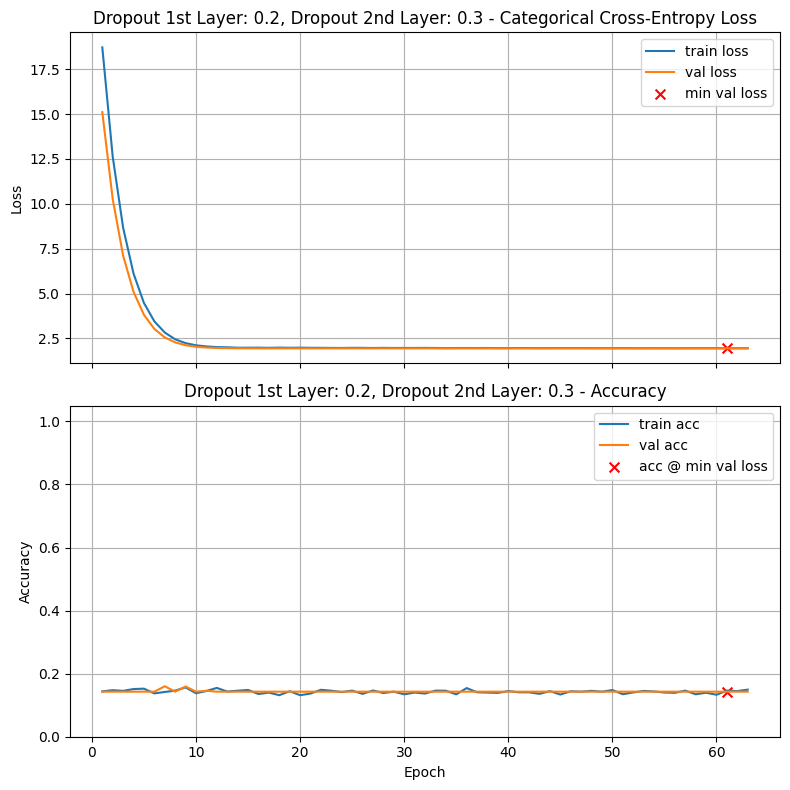

Final Training Loss:            1.9539
Final Training Accuracy:        0.1493
Final Validation Loss:          1.9462
Final Validation Accuracy:      0.1429
Minimum Validation Loss:        1.9461 (Epoch 61)
Validation Accuracy @ Min Loss: 0.1429

Test Loss: 1.9462
Test Accuracy: 0.1429

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:12

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4



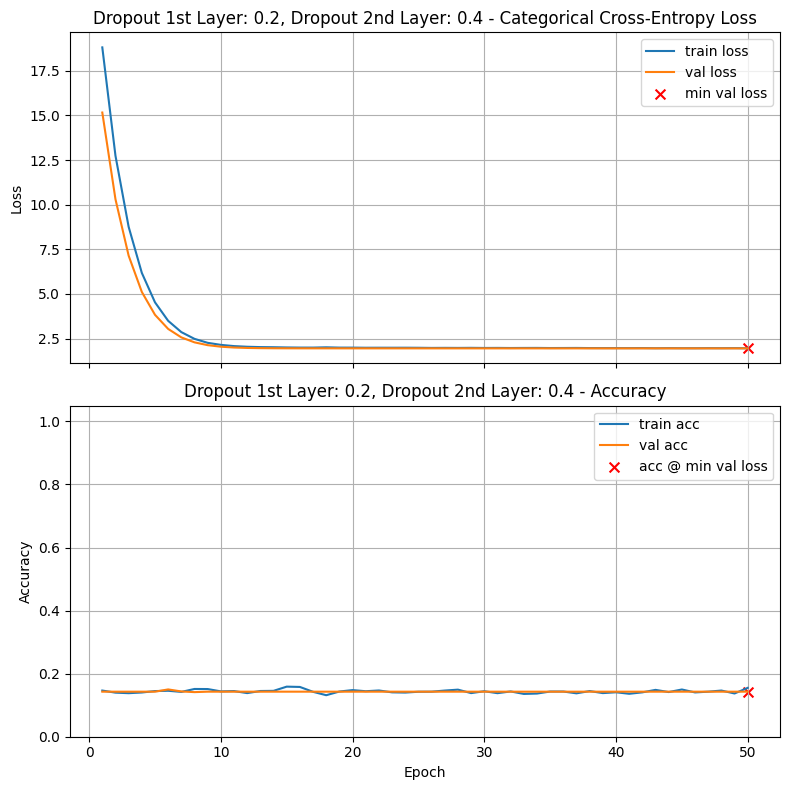

Final Training Loss:            1.9536
Final Training Accuracy:        0.1550
Final Validation Loss:          1.9463
Final Validation Accuracy:      0.1429
Minimum Validation Loss:        1.9463 (Epoch 50)
Validation Accuracy @ Min Loss: 0.1429

Test Loss: 1.9463
Test Accuracy: 0.1429

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:10

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5



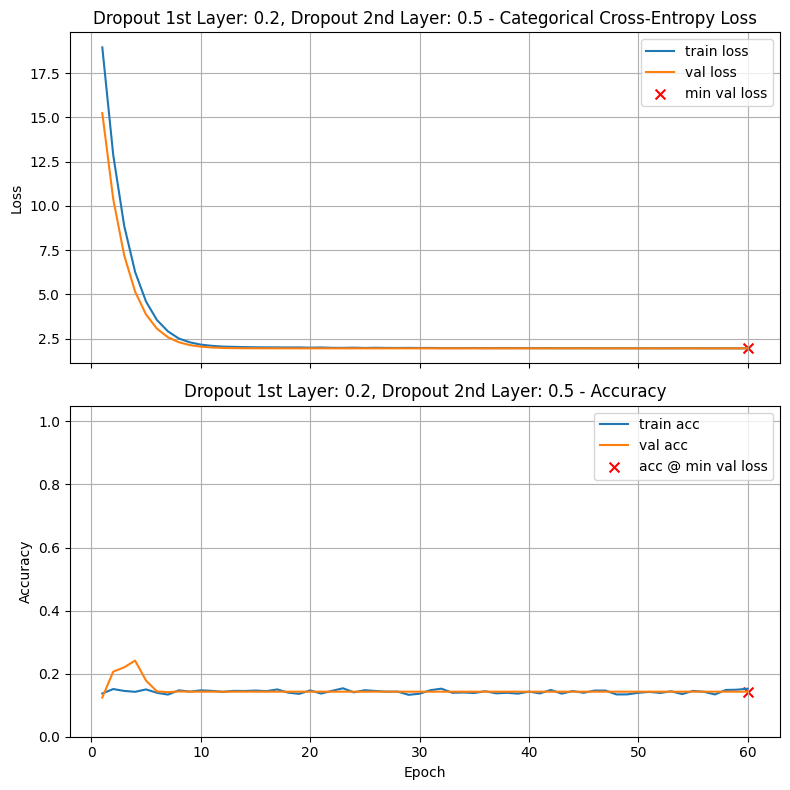

Final Training Loss:            1.9485
Final Training Accuracy:        0.1524
Final Validation Loss:          1.9460
Final Validation Accuracy:      0.1429
Minimum Validation Loss:        1.9460 (Epoch 60)
Validation Accuracy @ Min Loss: 0.1429

Test Loss: 1.9461
Test Accuracy: 0.1429

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:11


In [20]:
# Your code here. Add as many cells as you need.
learning_rate = [5e-4]
activation_function = ['sigmoid']

drop_out_1st_layer = [0.0, 0.1, 0.2]
drop_out_2nd_layer = [0.3, 0.4, 0.5]

for i in drop_out_1st_layer:
    for j in drop_out_2nd_layer:
        model = build_model(X_train.shape[1], [ (64, activation_function[0], i, j), (32, activation_function[0], i, j)], n_classes)
        train_and_test(model, lr_schedule=learning_rate, title=f"Dropout 1st Layer: {i}, Dropout 2nd Layer: {j}", verbose=0, return_history = True)


In [ ]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0,0.0)             # Replace (0.0,0.0) with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.0)


In [ ]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.0000


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


In [ ]:
# Your code here. Add as many cells as you need. 


In [ ]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0,0.0)             # Replace (0.0,0.0) with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0, 0.0)


In [ ]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.0000


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



In [ ]:
# Your code here. Add as many cells as you need.


In [ ]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.0000


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [ ]:
# Your code here


In [ ]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.0             # Replace 0.0 with your answer

In [ ]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.0000


### Optional: Print out your results of all experiments

In [ ]:
print_results()

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?